## Introduction
 This demonstrates a Image classifier based on different Loss function that is Hinge loss and the softmax loss based on th CIFAR-10 dataset which well described in this notebook. Hope this gives a great intution of different losses for developing your SVM model.

### Importing Libraries

In [1]:
import numpy as np
from random import shuffle
import random
import platform
import pickle
import os
import matplotlib.pyplot as plt

## <font color='#3883cd'>SVM loss</font><br>
The SVM loss is set up so that the SVM desires that the correct class for each image to a have a score higher than the incorrect classes by some fixed margin Δ.<br>
The score function takes the pixels and computes the vector f(xi,W) of class scores.<br>
The scores are interpreted as follows.<br>
 For example, the score for the j-th class is the j-th element: $s_j = f(x_i, W)_j$.<br>
 The Multiclass SVM Loss for the i-th example is formulized as:$$L_i = \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta)$$.<br>
 The above equation can be interpreted as:$$L_i = \sum_{j\neq y_i} \max(0, w_j^T x_i - w_{y_i}^T x_i + \Delta)$$<br>
 where $w_j$ is the j-th row of $W$ reshaped as a column. However, this will not necessarily be the case once we start to consider more complex forms of the score function $f$.<br>
The threshold at zero $max(0,−)$ function is often called the hinge loss.<br>
We can use the squred hinge loss which penalizes the violated margins more strongly(quadratically instead of linearly) $max(0,-)^2$. The unsquared hinge loss is more standard in some datasets but the squared loss can work better.<br>
The `Gradient` is calculated as :
$$\frac{\partial L_i}{\partial w_{y_i}}=-\sum\left(x_iw_j-x_iw_{y_i}+\mathrm{\Delta}>0\right)x_i$$

In [2]:
def svm_loss_vectorized(W,X,y,reg):
    """
    We calculate the loss and the gradient to better adjust the margins
    for the classification.
    Returns the gradient(dW) and loss
    """
    loss = 0.0
    dW = np.zeros(W.shape)
    num_train = X.shape[0]
    
    s = X.dot(W)
    #Getting the correct scores
    correct_score = s[list(range(num_train)),y]
    
    correct_score = correct_score.reshape(num_train,-1)
    
    #Now adding the margin and subtracting the scores
    # sj - syi +1
    s += 1-correct_score
    
    #Making all the correct scores to zero as we find the max value in the loss, and the correct scores
    #don't contribute to the loss function.
    s[list(range(num_train)),y] = 0
    
    loss = np.sum(np.fmax(s,0))/num_train
    
    #adding the L2 regularization term
    loss += reg * np.sum(W * W) 
    
    #Now calculating the gradient.
    X_mask = np.zeros(s.shape) #Binarize the margins.
    X_mask[ s > 0] = 1 
    X_mask[np.arange(num_train),y] = -np.sum(X_mask,axis = 1)
    dW = X.T.dot(X_mask)
    dW = dW / num_train
    #Left with only the regularization term.
    dW += 2 * reg * W 
    
    return loss,dW

In [3]:
class LinearClassifier(object):
    def __init__(self):
        #print('new class')
        self.W = None
    def train(self,X,y,learning_rate=1e-3,reg=1e-5,num_iters=100,batch_size=200,
             verbose=False):
        
        num_train,dim = X.shape
        num_classes = np.max(y)+1
        if self.W is None:
            self.W = 0.001*np.random.randn(dim,num_classes)
        #Intialte the SGD
        loss_history = []
        for it in range(num_iters):
            x_batch = None
            y_batch = None
            
            #Considering a sample randomly
            sample_indices = np.random.choice(np.arange(num_train),batch_size)
            x_batch = X[sample_indices]
            y_batch = y[sample_indices]
            
            #Finding the loss and computing the gradient
            loss,grad = self.loss(x_batch,y_batch,reg)
            loss_history.append(loss)
            
            #Updating the weights based on the gradient
            self.W += -learning_rate * grad
            
            #Printing the loss over verbose, to have a track
            if verbose and it%100 == 0:
                print(f'iteration {it} / {num_iters}: loss {loss}')
        return loss_history
    def loss(self,X_batch,y_batch,reg):
        pass
    def predict(self,X):
        """
        Using the trained weights of the classifier to predict the labels.
        Inputs:
        X - A numpy array of the shape (N,D) containing N training exampels and
        samples of dimension D
        
        Return:
        y_pred - Predicted labels of X, where y_pred is a 1-Dim array of length N.
        
        
        """
        y_pred = np.zeros(X.shape[0])
        
        scores = X.dot(self.W)
        
        #finding which class has the max score.
        y_pred = np.argmax(scores,axis=1) 
        return y_pred

In [4]:
class LinearSVM(LinearClassifier):
    """ Here we are inheriting the above class LinearClassifier to
        calculate the hinge loss."""
    
    
    #Calculating the SVM loss.
    def loss(self,X_batch,y_batch,reg):    
        return svm_loss_vectorized(self.W,X_batch,y_batch,reg)

## Reading the CIFAR-10.
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. <br>
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. <br>
Below we read the data_batches to train our model and also the test set to test our built models.

In [5]:
#Please store the directory path in this variable.
cifar10_dir = 'cifar-10-batches-py'

In [6]:
def load_pickle(f):
    #Checking the different versions of python to read the pickle file.
    version = platform.python_version_tuple()
    if version[0]=='2':
        return pickle.load(f)
    elif version[0] == '3':
        return pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
    
def load_CIFAR_batch(filename):
    "Loading the batch of cifar"
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float')
        Y = np.array(Y)
        return X, Y

In [7]:
def load_CIFAR10(ROOT):
    """ load all of cifar
    input - the directory of the cifar"""
    xs = []
    ys = []
    for b in range(1,6):
        #Loading all the 6 data_batch files.
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [8]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Having a look at the data.

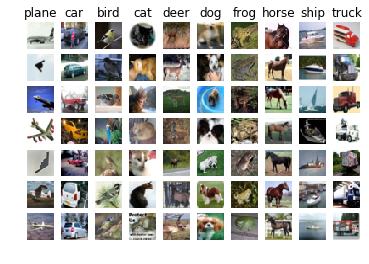

In [9]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Splitting the data to the train, test and the valiadation sets.<br>
creating  a small development set as a subset of the training data;
we can use this for development so our code runs faster.

In [10]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500


# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Creating a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Pre-processing the images.<br>

1. Flattening the image data.
2. Noramilizing the images.
3. Appending the bias for easy computation.

### Flattening the image data.

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


### Computing the mean of the images.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


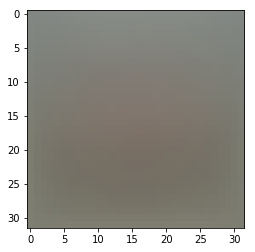

In [12]:
mean_image = np.mean(X_train, axis=0)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
#Visualizing the mean image
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

In [13]:
#subtracting the mean image from the data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

### Appending the bias term

In [14]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


### Training our model with the hinge loss function we defined above.

In [15]:
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 1565.3410521775688
iteration 100 / 1500: loss 211.71502032418513
iteration 200 / 1500: loss 33.031559250847856
iteration 300 / 1500: loss 9.24279228672616
iteration 400 / 1500: loss 5.405225263806571
iteration 500 / 1500: loss 5.7550938637697655
iteration 600 / 1500: loss 5.993097433605136
iteration 700 / 1500: loss 5.768547086599422
iteration 800 / 1500: loss 5.547081586082131
iteration 900 / 1500: loss 5.921533077923453
iteration 1000 / 1500: loss 5.7658451234746435
iteration 1100 / 1500: loss 5.877414026664849
iteration 1200 / 1500: loss 6.224559653167108
iteration 1300 / 1500: loss 5.4728754580106695
iteration 1400 / 1500: loss 5.491942855525023


Plotting the Loss against the number of iterations to check wether is performing well.<br>
We can check this by as that the loss should decrease as the number of iterations increase.

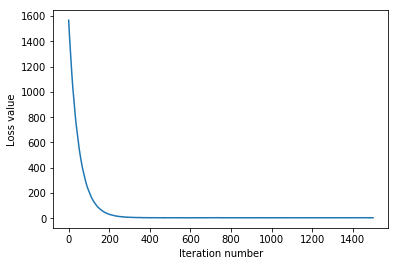

In [16]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Checking on the training accuracy and the validation accuracy.

In [17]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.345061
validation accuracy: 0.351000


Now implementing the cross validation for a better accuracy, to decide on to the hyperparameters.

In [18]:
learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


svm = LinearSVM()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
        

    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)



lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.250286 val accuracy: 0.255000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.345755 val accuracy: 0.346000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370612 val accuracy: 0.379000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.353184 val accuracy: 0.354000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.353204 val accuracy: 0.351000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.354531 val accuracy: 0.361000
best validation accuracy achieved during cross-validation: 0.379000


From the above we can see that the best model is when the learning rate is $1.000000e^-7$ and the penalty term as $2.500000e^4$.<br>
Now visualizing the cross-validation results.

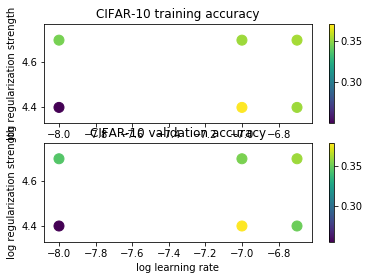

In [19]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

### Evaluting the model on the test data.

In [20]:
y_test_pred = best_svm.predict(X_test)

#calculating the accuracy based on the predicted classes.
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.361000


### Visualizing the trained weights for all the 10 classes.

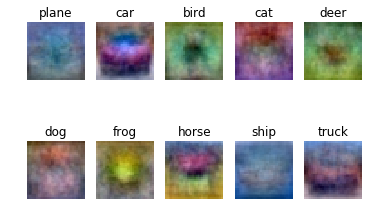

In [21]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## SVM with Softmax loss.

## <font color='#3883cd'>Softmax</font><br>
The Softmax is a generalization of binay Logistic regression classifier.<br>
In softmax we replace the hinge loss with the cross-entropy loss as $$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}$$<br>
- Where $f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}}$ is the `soft max function`.<br>
- $L_i$ is the loss for classifying a single example $x_i$<br>
- $y_i$ is the index of the correct class of $x_i$.<br>
- $f_j$ is the predicted class j, computed by $x_iw_j$.<br>
- The $L_i$ equation is the loss which minimizes the score of predicting the correct class class $y_i$ is maximized and accumilated scores for predicting other classes ($f_j$) is minimized.<br>
- The gradient of the Softmax loss is given as:<br>
$$\frac{dL_i}{dw_j}=\left(\frac{e^{f_y}i}{\sum_{j}{e^fj}}-1\right)x_{\dot{i}}$$

Implementing the softmax loss

In [22]:
def softmax_loss(W,X,y,reg):
    loss = 0.0
    dW = np.zeros_like(W)
    
    num_train,num_classes = X.shape
    
    f = X.dot(W)
    f -= np.max(f, axis=1, keepdims=True) # max of every sample
    sum_f = np.sum(np.exp(f), axis=1, keepdims=True)
    
    #Performing the normalization
    p = np.exp(f)/sum_f
    
    #Applying the -ve log 
    loss = np.sum(-np.log(p[np.arange(num_train), y]))
    loss /= num_train
    #adding up the L2 term
    loss += 0.5 * reg * np.sum(W * W)
    
    #Calcualting the gradient.
    ind = np.zeros_like(p)
    ind[np.arange(num_train), y] = 1
    dW = X.T.dot(p - ind)
    dW /= num_train
    #L2 term
    dW += reg*W
    return loss,dW

In [23]:
class softmax_svm(LinearClassifier):
    
    
    #Calculating the SVM loss.
    def loss(self,X_batch,y_batch,reg):   
        #print('calculating the loss')
        return softmax_loss(self.W,X_batch,y_batch,reg)

In [24]:
clf=softmax_svm()
loss_hist = clf.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 769.0584902344808
iteration 100 / 1500: loss 282.22693936057095
iteration 200 / 1500: loss 104.49979014101716
iteration 300 / 1500: loss 39.551214241768356
iteration 400 / 1500: loss 15.760907081787636
iteration 500 / 1500: loss 7.055887703129061
iteration 600 / 1500: loss 3.9675801341954555
iteration 700 / 1500: loss 2.8190261397263043
iteration 800 / 1500: loss 2.333297245828958
iteration 900 / 1500: loss 2.236972175990685
iteration 1000 / 1500: loss 2.156055537009733
iteration 1100 / 1500: loss 2.148880660529588
iteration 1200 / 1500: loss 2.1358484513756504
iteration 1300 / 1500: loss 2.0948930701019486
iteration 1400 / 1500: loss 2.101418678295694


Plotting up the Loss Vs number of iterations.

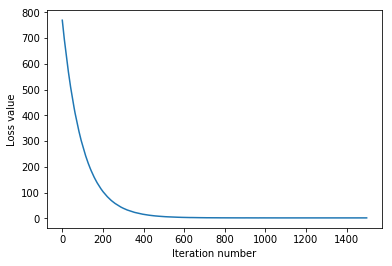

In [25]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [26]:
y_train_pred = clf.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = clf.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329531
validation accuracy: 0.350000


<b> Implementing the cross-validation for the best model and finding the best leaerning rate and the regularization parameter.

In [27]:
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [5e2, 1e3, 1e4, 5e4]


softmax = softmax_svm()

for lr in learning_rates:
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500)
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
        
        
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.160796 val accuracy: 0.156000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.185041 val accuracy: 0.175000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.202755 val accuracy: 0.182000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.235571 val accuracy: 0.224000
lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.336776 val accuracy: 0.354000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.366673 val accuracy: 0.375000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.377571 val accuracy: 0.390000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.330633 val accuracy: 0.350000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.411551 val accuracy: 0.402000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.411531 val accuracy: 0.413000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.375469 val accuracy: 0.387000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.322327 val accuracy: 0.339000
lr 1.000000e-06 reg 5.000000

From the above we can see that the best model for the data is <br>
learning rate = $5.000000e^-7$<br>
reg_parameter = $5.000000e^2$<br>
which is resulting in a train accuaracy of $0.409816$ and validation accuracy of $0.412000$.

Visualizing the learned weights based on the softmax loss.

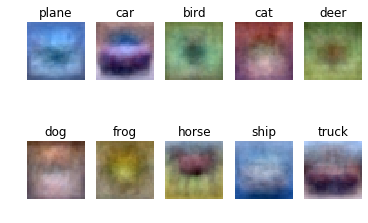

In [28]:
#lets us strip out the bias
w = best_softmax.W[:-1,:] 
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### <font color='#3883cd'> SVM Vs Softmax </font><br>
In both the cases we calculate the sscores but we interpret in a different way.<br>
- In case of SVM, interprets these scores as class scores and its loss function encourages the correct class (class 2, in blue) to have a score higher by a margin than the other class scores.<br>
- The Softmax classifier instead interprets the scores as (unnormalized) log probabilities for each class and then encourages the (normalized) log probability of the correct class to be high (equivalently the negative of it to be low).<br>
- Softmax classifier provides “probabilities” for each class. Unlike the SVM which computes uncalibrated and not easy to interpret scores for all classes, the Softmax classifier allows us to compute “probabilities” for all labels.<br>
<b> At last the difference between these 2 loss functions is very small, The SVM loss is of more local objective which can be considered as a bug or a featuredepeending on the data, generraly we can also say that the SVM dosen't consider the details of the individual scores. In case of softmax loss the probability of the correct class is always high and the probability of other classes is low which leads to better improvement of loss.

## References
1. The dataset CIFAR-10 https://www.cs.toronto.edu/~kriz/cifar.html